In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import models
import constants

In [2]:
folder = './data/'
days = 3
steps = 1000

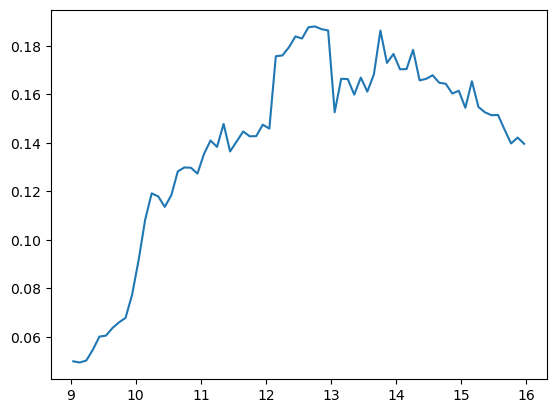

In [3]:
input_file = pd.read_csv(folder+'input_irradiance_mel.csv', sep=";", decimal=",")
# input_file
plt.plot(input_file['hours'], input_file['irradiance_mel'])

In [4]:
def irradiance(
    t,
    input_irradiance,
    waketime=6,
    bedtime=22,
    morning_cutoff=7.5,
    afternoon_cutoff=17,
    evening_cutoff=19,
    default_night_exposure=0,
    default_day_exposure=50,
    default_evening_exposure=10,
    ramp=False,
):
    """Irradiance Function
    Inputs:
        t: time in seconds
        input_irradiance: input irradiance data
        waketime: time to wake up in hours
        bedtime: time to sleep in hours
        morning_cutoff: time to start morning light exposure in hours
        afternoon_cutoff: time to start afternoon light exposure in hours
        evening_cutoff: time to start evening light exposure in hours
        default_night_exposure: default night exposure in lux
        default_day_exposure: default day exposure in lux
        default_evening_exposure: default evening exposure in lux
    Outputs:
        output_irradiance: Melanopic Irradiance
    
    The default shape of the irradiance curve is dictated by C. Pierson.
    """

    t = t % (24 * 3600)

    if t <= waketime * 3600 or t >= bedtime * 3600:
        output_irradiance = default_night_exposure / constants.CONVERSION_FACTOR
    elif t < morning_cutoff * 3600:
        if ramp:
            output_irradiance = (
                default_night_exposure
                + (
                    (t - waketime * 3600)
                    / 3600
                    / (morning_cutoff - waketime)
                    * default_day_exposure
                )
            ) / constants.CONVERSION_FACTOR
        else:
            output_irradiance = default_day_exposure / constants.CONVERSION_FACTOR
    elif t > afternoon_cutoff * 3600 and t < evening_cutoff * 3600:
        if ramp:
            output_irradiance = (
                default_day_exposure
                - (
                    (t - afternoon_cutoff * 3600)
                    / 3600
                    / (evening_cutoff - afternoon_cutoff)
                    * (default_day_exposure - default_evening_exposure)
                )
            ) / constants.CONVERSION_FACTOR
        else:
            output_irradiance = default_day_exposure / constants.CONVERSION_FACTOR
    elif t > evening_cutoff * 3600 and t < bedtime * 3600:
        output_irradiance = default_evening_exposure / constants.CONVERSION_FACTOR
    else:
        csv_hours = input_irradiance["hours"].values
        csv_irradiance_mel = input_irradiance["irradiance_mel"].values

        interpolator = interp1d(
            csv_hours,
            csv_irradiance_mel,
            kind="cubic",
            bounds_error=False,
            fill_value=(csv_irradiance_mel[0], csv_irradiance_mel[-1]),
        )
        output_irradiance = interpolator(t / 3600)

    return output_irradiance

t = np.linspace(0, days*24*60*60, steps)
input_irradiance = [irradiance(time, input_file) for time in t]

In [5]:
# Manual test of the irradiance function
from datetime import datetime, timedelta
from scipy.interpolate import interp1d
interpolator = interp1d(
        t,
        input_irradiance,
        kind="cubic",
        bounds_error=False,
        fill_value=(input_irradiance[0], input_irradiance[-1]),
    )

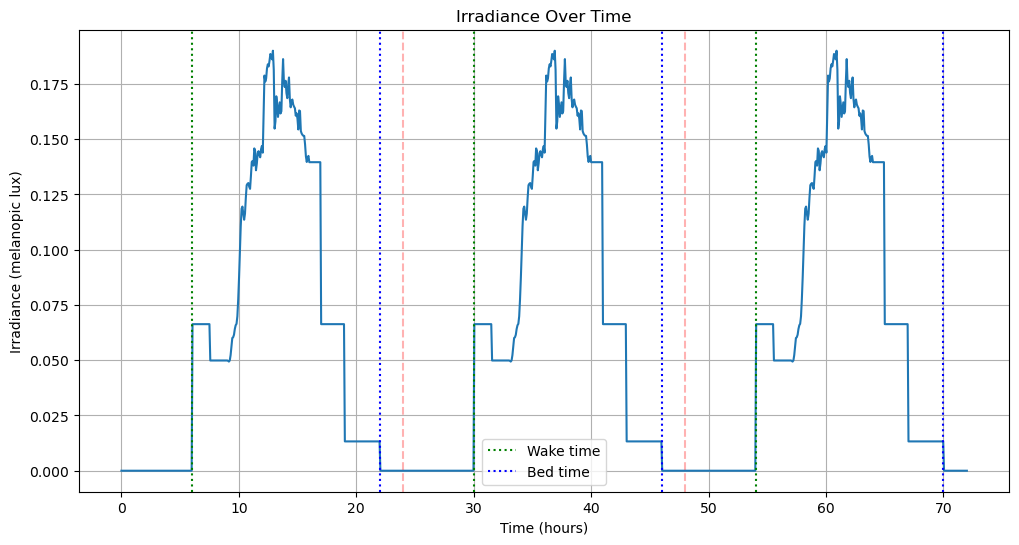

In [6]:
# Running the model over 5 days, 1000 steps in DEBUG mode to see irradiance plot
# run again if division by zero encountered
(sol, t) = models.model_run(days, steps, interpolator=interpolator, debug=True)
# (sol, t) = models.model_run(days, steps, input_irradiance=input_irradiance, time_points=t, debug=True)

In [7]:
# Extracting all the variables from the model
V_v = sol[:, 0]
V_m = sol[:, 1]
H = sol[:, 2]
X = sol[:, 3]
Y = sol[:, 4]
P = sol[:, 5]
Theta_L = sol[:, 6]
A = sol[:,7]
rho_b = sol[:, 8]
t_hours = t/3600

In [8]:
# Calculation aMT6s
aMT6s = [models.urinary_excretion_rate(rho_b, t, time) for time in t]

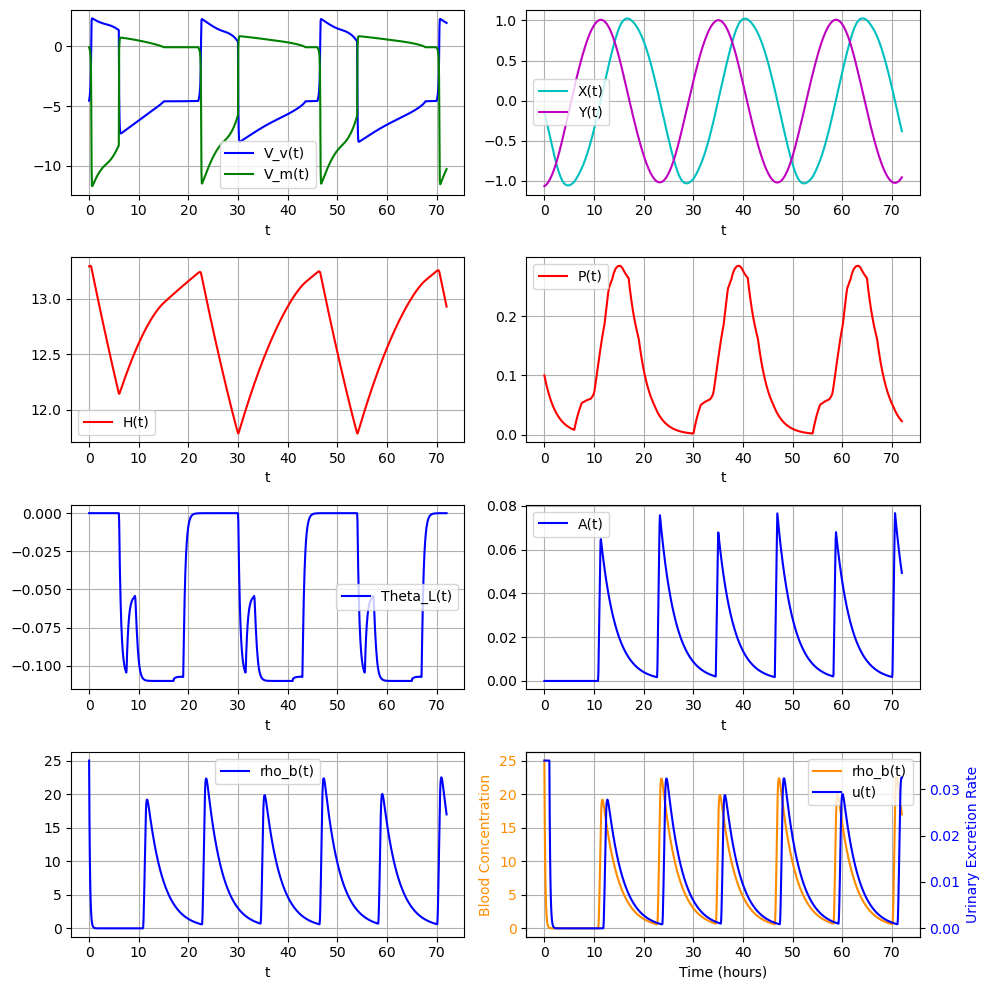

In [9]:
### Plot ODEs
plt.figure(figsize=(10, 10))

plt.subplot(4,2,1)
plt.plot(t_hours, V_v, 'b', label='V_v(t)')
plt.plot(t_hours, V_m, 'g', label='V_m(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid(True)

plt.subplot(4,2,2)
plt.plot(t_hours, X, 'c', label='X(t)')
plt.plot(t_hours, Y, 'm', label='Y(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid(True)

plt.subplot(4,2,3)
plt.plot(t_hours, H, 'r', label='H(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid(True)

plt.subplot(4,2,4)
plt.plot(t_hours, P, 'r', label='P(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid(True)

plt.subplot(4,2,5)
plt.plot(t_hours, Theta_L, 'b', label='Theta_L(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid(True)

plt.subplot(4,2,6)
plt.plot(t_hours, A, 'b', label='A(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid(True)

plt.subplot(4,2,7)
plt.plot(t_hours, rho_b, 'b', label='rho_b(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid(True)

plt.subplot(4,2,8)
# Primary axis for rho_b
ax1 = plt.gca()
ax1.plot(t_hours, rho_b, label='rho_b(t)', color='darkorange')
ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Blood Concentration', color='darkorange')
ax1.tick_params(axis='y', labelcolor='darkorange')
ax1.grid(True)

# Secondary axis for aMT6s
ax2 = ax1.twinx()
ax2.plot(t_hours, aMT6s, label='u(t)', color='blue')
ax2.set_ylabel('Urinary Excretion Rate', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Create combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()
plt.show()

In [10]:
# Calculating circadian and alterness measures
C = models.circadian_drive_v(X,Y)
AM = models.alertness_measure_v(C, H, Theta_L)

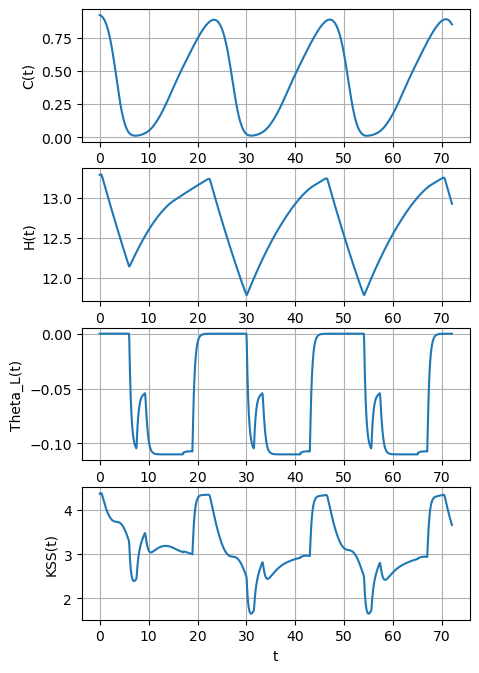

In [11]:
### Plot AM-related variables
plt.figure(figsize=(5, 10))

plt.subplot(5,1,1)
plt.plot(t_hours, C)
plt.xlabel('t')
plt.ylabel('C(t)')
plt.grid(True)

plt.subplot(5,1,2)
plt.plot(t_hours, H)
plt.xlabel('t')
plt.ylabel('H(t)')
plt.grid(True)

plt.subplot(5,1,3)
plt.plot(t_hours, Theta_L)
plt.xlabel('t')
plt.ylabel('Theta_L(t)')
plt.grid(True)

plt.subplot(5,1,4)
plt.plot(t_hours, AM)
plt.xlabel('t')
plt.ylabel('KSS(t)')
plt.grid(True)

In [12]:
# Importing Comparison Data
comparison = pd.read_csv(folder+"output.csv", sep=";", decimal=",")
n = comparison.shape[0]
comparison['irradiance_mel'] = comparison.I_mel*0.0013262 # convert to irradiance
comparison['hours'] = comparison.time
# comparison

In [13]:
# Model for comparison
t = np.linspace(0, days*24*60*60, steps)
input_irradiance = [irradiance(time, input_file, waketime = 8, bedtime = 20, morning_cutoff=9, afternoon_cutoff=16, default_day_exposure= 165, default_evening_exposure=165, default_night_exposure=27, ramp = False,) for time in t]
interpolator = interp1d(
        t,
        input_irradiance,
        kind="cubic",
        bounds_error=False,
        fill_value=(input_irradiance[0], input_irradiance[-1]),
    )
(sol, t) = models.model_run(days, steps, interpolator=interpolator, waketime = 8, bedtime = 20)

In [14]:
# Extracting all the variables from the model
V_v = sol[:, 0]
V_m = sol[:, 1]
H = sol[:, 2]
X = sol[:, 3]
Y = sol[:, 4]
P = sol[:, 5]
Theta_L = sol[:, 6]
A = sol[:,7]
rho_b = sol[:, 8]
t_hours = t/3600
C = models.circadian_drive_v(X,Y)
AM = models.alertness_measure_v(C, H, Theta_L)

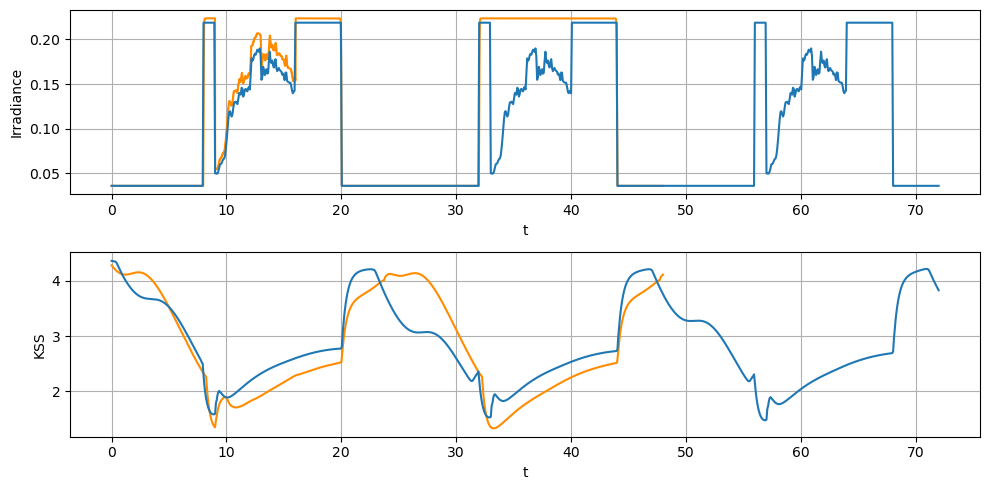

In [15]:
### Plot KSS and Irradiance for Comparison
plt.figure(figsize=(10,5))

plt.subplot(2,1,1)
plt.plot(comparison['hours'], comparison['irradiance_mel'], 'darkorange')
plt.plot(t/3600, input_irradiance)
plt.xlabel('t')
plt.ylabel('Irradiance')
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(comparison['hours'], comparison['KSS'], 'darkorange')
plt.plot(t_hours, AM)
plt.xlabel('t')
plt.ylabel('KSS')
plt.grid(True)

plt.tight_layout()
plt.show()

In [21]:
### Compute all the internal functions
IE    = [models.irradiance(time, interpolator) for time in t]
S     = models.state_v(V_m) 
alpha = models.photoreceptor_conversion_rate_v(IE, S, "2020")
Q_m   = models.mean_population_firing_rate_v(V_m)
Q_v   = models.mean_population_firing_rate_v(V_v)
C     = models.circadian_drive_v(X,Y)
D_v   = models.total_sleep_drive_v(H,C)
D_n   = models.nonphotic_drive_v(X, S)
D_p   = models.photic_drive_v(X, Y, P, alpha)
F_w   = models.forced_wake_v(t)
W     = models.wake_effort_v(Q_v, F_w)
r     = models.melatonin_suppression_v(IE)
phi   = models.circadian_phase_v(X,Y)
m_phi = models.melatonin_synthesis_regulation_v(phi)
# Sigmoid = ( models.sigmoid_v(IE) - models.sigmoid_v(0) ) / ( models.sigmoid_v(1000) - models.sigmoid_v(0) )
Sigmoid = models.sigmoid_v(IE)

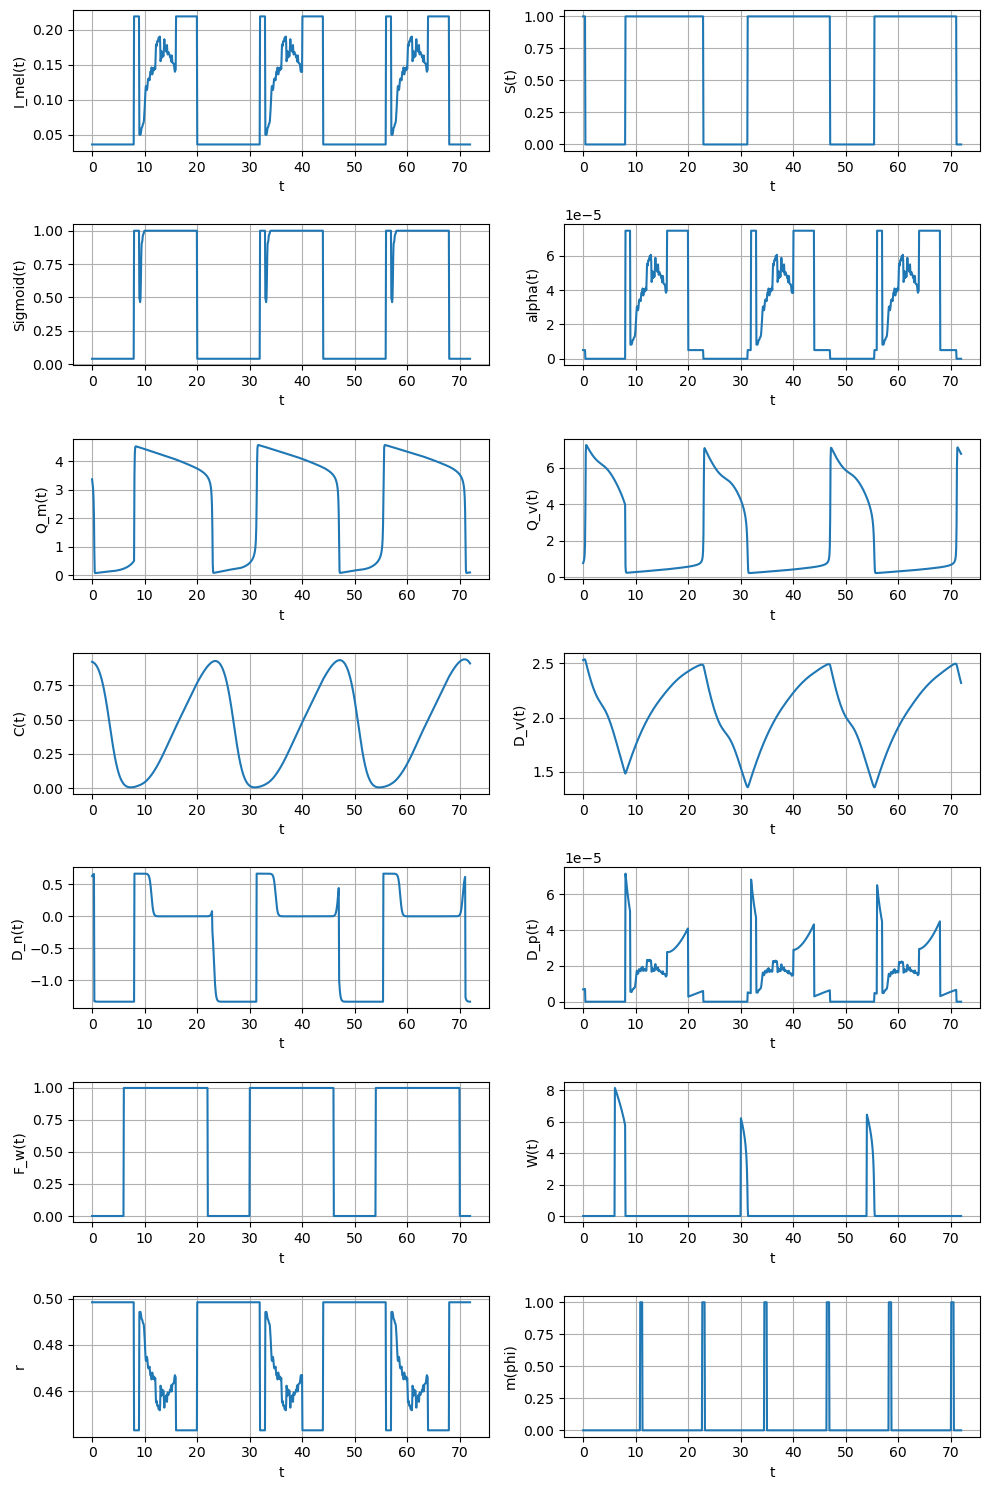

In [25]:
### Plot internal variables
plt.figure(figsize=(10, 15))

plt.subplot(7,2,1)
plt.plot(t_hours, IE)
plt.xlabel('t')
plt.ylabel('I_mel(t)')
plt.grid(True)

plt.subplot(7,2,2)
plt.plot(t_hours, S)
plt.xlabel('t')
plt.ylabel('S(t)')
plt.grid(True)

plt.subplot(7,2,3)
plt.plot(t_hours, Sigmoid)
plt.xlabel('t')
plt.ylabel('Sigmoid(t)')
plt.grid(True)

plt.subplot(7,2,4)
plt.plot(t_hours, alpha)
plt.xlabel('t')
plt.ylabel('alpha(t)')
plt.grid(True)

plt.subplot(7,2,5)
plt.plot(t_hours, Q_m)
plt.xlabel('t')
plt.ylabel('Q_m(t)')
plt.grid(True)

plt.subplot(7,2,6)
plt.plot(t_hours, Q_v)
plt.xlabel('t')
plt.ylabel('Q_v(t)')
plt.grid(True)

plt.subplot(7,2,7)
plt.plot(t_hours, C)
plt.xlabel('t')
plt.ylabel('C(t)')
plt.grid(True)

plt.subplot(7,2,8)
plt.plot(t_hours, D_v)
plt.xlabel('t')
plt.ylabel('D_v(t)')
plt.grid(True)

plt.subplot(7,2,9)
plt.plot(t_hours, D_n)
plt.xlabel('t')
plt.ylabel('D_n(t)')
plt.grid(True)

plt.subplot(7,2,10)
plt.plot(t_hours, D_p)
plt.xlabel('t')
plt.ylabel('D_p(t)')
plt.grid(True)

plt.subplot(7,2,11)
plt.plot(t_hours, F_w)
plt.xlabel('t')
plt.ylabel('F_w(t)')
plt.grid(True)

plt.subplot(7,2,12)
plt.plot(t_hours, W)
plt.xlabel('t')
plt.ylabel('W(t)')
plt.grid(True)

plt.subplot(7,2,13)
plt.plot(t_hours, r)
plt.xlabel('t')
plt.ylabel('r')
plt.grid(True)

plt.subplot(7,2,14)
plt.plot(t_hours, m_phi)
plt.xlabel('t')
plt.ylabel('m(phi)')
plt.grid(True)

plt.tight_layout()
plt.show()